In [1845]:

from experiment_information import *
from data import *
from util import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1846]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)
# print("Current code version, ", __version__)

In [1847]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "52"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,ps,dp,d,p,erm_methods,completed,data_model_type
54,36b92767-8700-441d-8b95-2b98b0d7aba4,Vanilla Strong Weak Trials,222.115832,53,2023-10-19 20:44:49,1,2,"[0.1, 3.0500000000000003, 6.0]","[0.0, 0.5]","[0.1, 1.0, 10.0]",[0],[0.75],0.01,1000,1000,"[""sklearn""]",1,SourceCapacity
53,936884bb-7c04-498c-873b-0a7bd3f7edb8,Vanilla Strong Weak Trials,73.530086,53,2023-10-19 20:42:39,1,2,"[0.1, 3.0500000000000003, 6.0]","[0.0, 0.5]","[0.1, 1.0, 10.0]",[0],[0.75],0.01,1000,1000,"[""sklearn""]",1,VanillaGaussian
52,3939dd1c-a3fd-42cd-baa4-5f131e99ada9,Vanilla Strong Weak Trials,72.451100,53,2023-10-19 20:40:52,1,2,"[0.1, 3.0500000000000003, 6.0]","[0.0, 0.5]","[0.1, 1.0, 10.0]",[0],[0.75],0.01,1000,1000,"[""sklearn""]",1,VanillaGaussian


In [1848]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [1849]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)
# experiment_id = "031d5eb9-bf79-4ffb-9fb3-eabedcd350b0"

# This guy was interesting in version 25 for the q- state evolution adaptation
# a2a3016c-8264-4599-ac8f-b457da2790ba
# this guy is interesting in version 28! q-state evolution - best erm so far, close call
# b5f9faf7-ec66-490c-ac99-841888f3fedf
# experiment_id = "b5f9faf7-ec66-490c-ac99-841888f3fedf"
# version 30: 7b921b61-0b48-48a8-8ead-78bc5804597f - q state evolution. Overlaps match except for lambda = 1 in the settings tau=0,2, lam=5*1e-5 for epsilon up to 0.7
# version 30: f92b13d1-c020-46c0-a3cd-5e0578b831a5 - Q state evolution. Same setting as above but not matching overlap.

# version 36 on cluster: 58b544ab-3536-4eb7-bbb9-743f471f6bb3

36b92767-8700-441d-8b95-2b98b0d7aba4


In [1850]:
round_to = 1
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"]) #,"p"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"]) #,"p"
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","cosb","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A_self","N_self","A_self_hat","N_self_hat","a","n","a_hat","n_hat"]] #,"calibration"
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","test_loss","adversarial_generalization_error_erm","adversarial_generalization_error_overlap","A","N"]] #"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm_erm","training_error_state_evolution","A_erm","N_erm","a_state_evolution","n_state_evolution","a_hat_state_evolution","n_hat_state_evolution","A_self_state_evolution","N_self_state_evolution","A_self_hat_state_evolution","N_self_hat_state_evolution"]] # ,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std]) #,4
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_36774/161452500.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))


generalization_error_state_evolution       \
                                                       mean  std   
alpha epsilon tau lam                                              
0.0   0.0     0.0 0.1                              0.121351  0.0   
                  1.0                              0.128562  0.0   
                  10.0                             0.159477  0.0   
      0.5     0.0 0.1                              0.121339  0.0   
                  1.0                              0.128856  0.0   
                  10.0                             0.160073  0.0   
3.0   0.0     0.0 0.1                              0.042703  0.0   
                  1.0                              0.051009  0.0   
                  10.0                             0.078025  0.0   
      0.5     0.0 0.1                              0.042953  0.0   
                  1.0                              0.052712  0.0   
                  10.0                             0.079888  0.0   
6.0   0.0     0.0 0.1                              0.032930  0.0   
                  1.0                              0.041551  0.0   
                  10.0                             0.066310  0.0   
      0.5     0.0 0.1                              0.033723  0.0   
                  1.0                              0.043847  0.0   
                  10.0                             0.068499  0.0   

                       generalization_error_erm_erm            \
                                               mean       std   
alpha epsilon tau lam                                           
0.0   0.0     0.0 0.1                       0.12025  0.021708   
                  1.0                       0.11745  0.001344   
                  10.0                      0.14930  0.018809   
      0.5     0.0 0.1                       0.12440  0.001414   
                  1.0                       0.11400  0.003818   
                  10.0                      0.15775  0.011243   
3.0   0.0     0.0 0.1                       0.04285  0.000354   
                  1.0                       0.05265  0.000354   
                  10.0                      0.07350  0.005940   
      0.5     0.0 0.1                       0.04245  0.000495   
                  1.0                       0.04980  0.002828   
                  10.0                      0.08080  0.004243   
6.0   0.0     0.0 0.1                       0.03130  0.000849   
                  1.0                       0.04130  0.000424   
                  10.0                      0.07045  0.003041   
      0.5     0.0 0.1                       0.03285  0.001061   
                  1.0                       0.04470  0.000990   
                  10.0                      0.06580  0.001556   

                       generalization_error_overlap_erm            \
                                                   mean       std   
alpha epsilon tau lam                                               
0.0   0.0     0.0 0.1                          0.121875  0.023742   
                  1.0                          0.119569  0.000842   
                  10.0                         0.150781  0.016347   
      0.5     0.0 0.1                          0.121662  0.000610   
                  1.0                          0.113637  0.001878   
                  10.0                         0.156516  0.013981   
3.0   0.0     0.0 0.1                          0.043424  0.003517   
                  1.0                          0.051942  0.001137   
                  10.0                         0.074206  0.004737   
      0.5     0.0 0.1                          0.042052  0.000770   
                  1.0                          0.052153  0.000088   
                  10.0                         0.079705  0.003170   
6.0   0.0     0.0 0.1                          0.031530  0.000113   
                  1.0                          0.040571  0.000888   
                  10.0                         0.067161

In [1851]:
def extract_optimal_lambda(alpha, epsilon, tau, recursion_depth = 0):
    # extract or compute optimal lamba and plot it as a vertical line
    filename = f"experiments/optimal_lambdas.csv"
    # read filename as pandas dataframe
    df_optimal_lambdas = pd.read_csv(filename)
    # filter the dataframe for the current value of tau, epsilon and alpha
    optimal_lambdas_subset = df_optimal_lambdas[(df_optimal_lambdas["tau"] == tau) & (df_optimal_lambdas["epsilon"] == epsilon) & (df_optimal_lambdas["alpha"] == alpha)]
    # extract the optimal lambda
    try:
        optimal_lambda = optimal_lambdas_subset["lambda"].values[0]
        return optimal_lambda
    except:
        if recursion_depth > 0:
            return None
        print("Optimal lambda not found. Computing it now.")
        command = f"python optimal_choice.py {alpha} {epsilon} {tau}"
        import subprocess
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        return extract_optimal_lambda(alpha,epsilon,tau,recursion_depth=recursion_depth+1)

In [1852]:
first_iteration = "tau"
second_iteration = "epsilon" # "lam"
target = "alpha"
sweep = "lam"
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = False, log_y=False, fix_a_variable = None, variable_value = None, filename=None):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2[first_iteration].unique():

        iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

        for lam in iterate_over:

            # Filter the dataframe for the current values of tau and lam
            if second_iteration is None:
                data = df2[(df2[first_iteration] == tau)]
            else:
                data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]

            if fix_a_variable is not None:
                data = data[data[fix_a_variable] == variable_value]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon}', color=palette[i])
                    else:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        plt.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass

                if error_name == "Generalization Error" and target == "lam":
                    optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau)
                    # plot the optimal lambda as a vertical line
                    plt.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

            
            if log_x:
                plt.xscale('log')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            if fix_a_variable is not None:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d} - {fix_a_variable}: {variable_value}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}')
            else:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            # add a grid
            plt.grid()

            plt.tight_layout()

            if fix_a_variable is not None:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
            else:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            if filename is not None:
                plt.savefig(f"Assets/{filename}_{name}.pdf", bbox_inches='tight')

            # Show the plot
            plt.show()

In [1853]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

In [1854]:
# create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

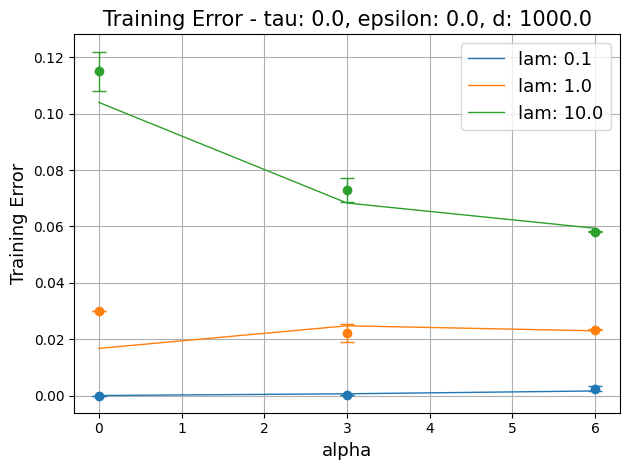

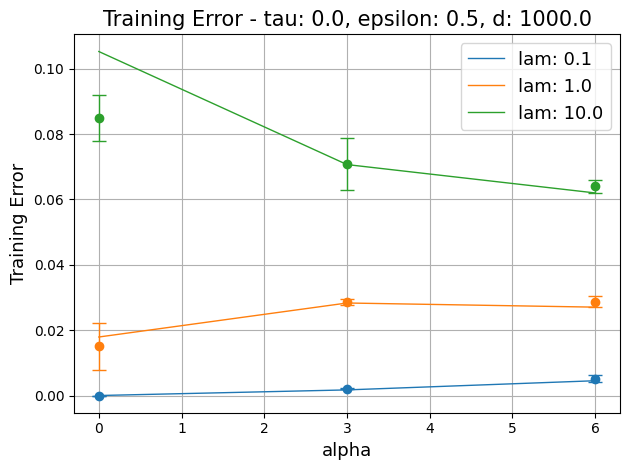

In [1855]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm",log_y=False)

In [1856]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

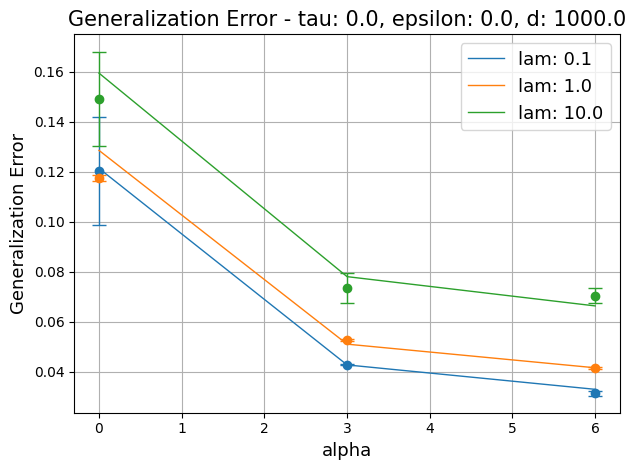

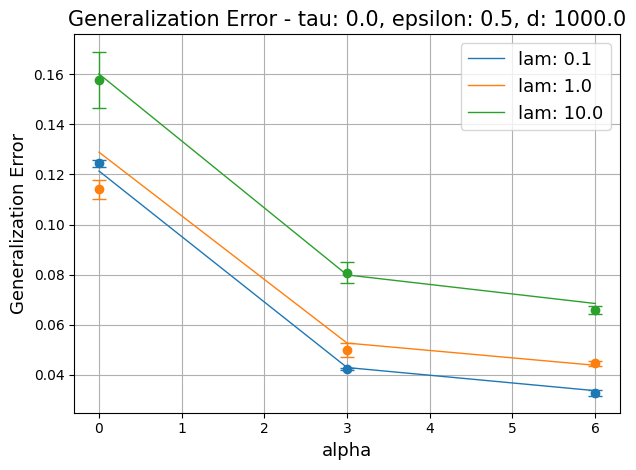

In [1857]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=False)

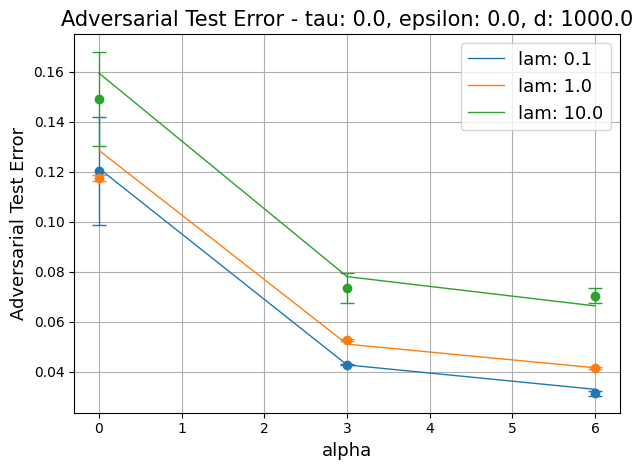

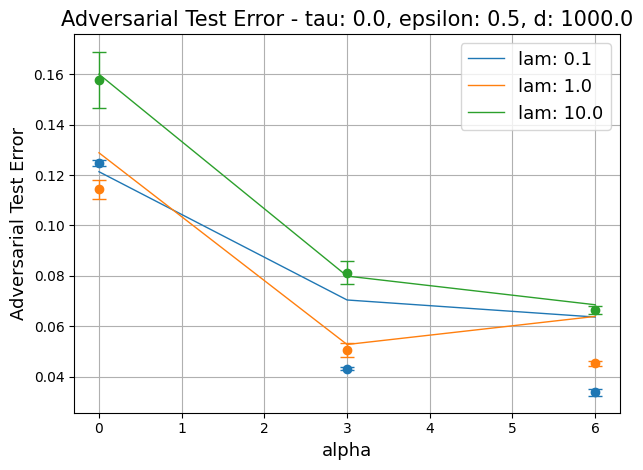

In [1858]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm_erm",log_y=False)

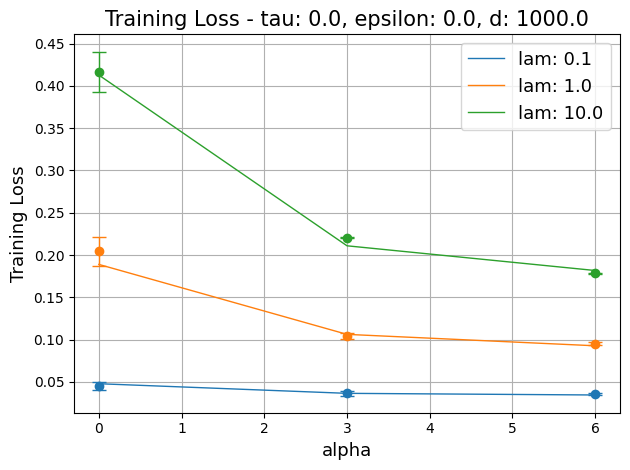

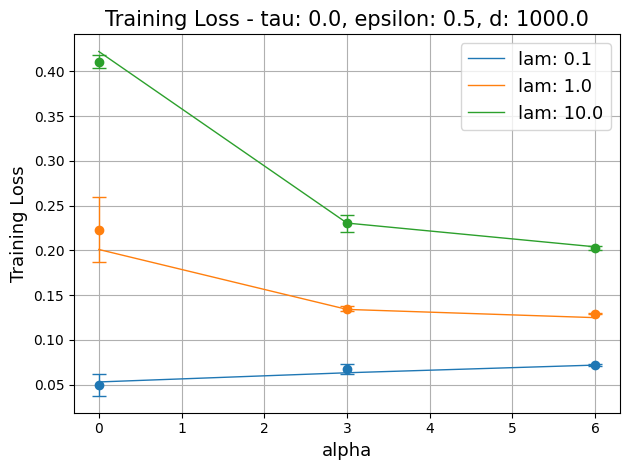

In [1859]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=False)

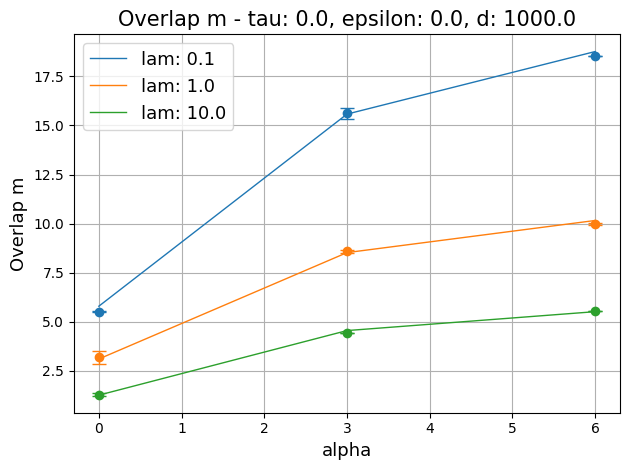

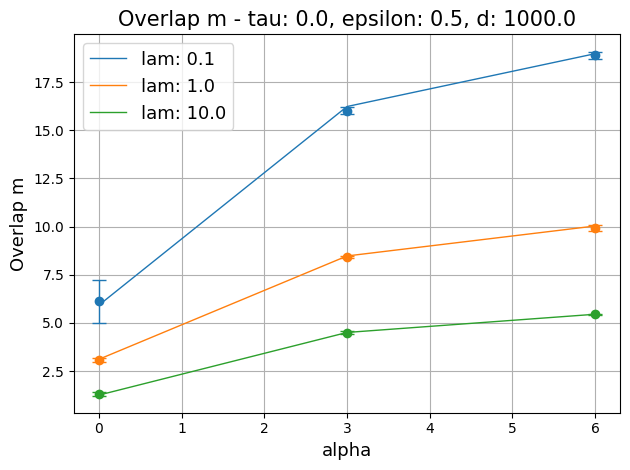

In [1860]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=False)

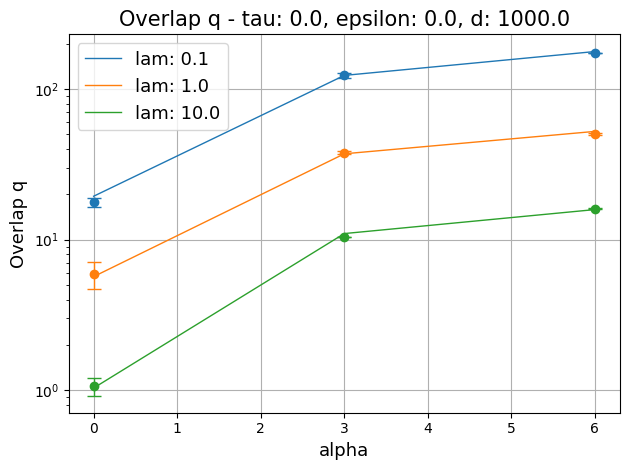

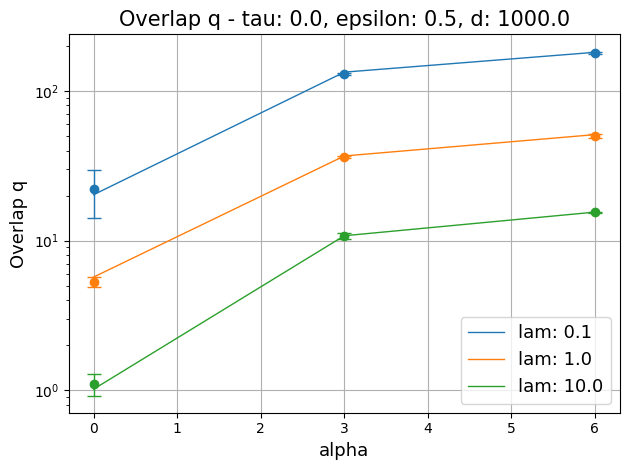

In [1861]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

In [1862]:
# Plot the Q_self_state_evolution overlap vs Q_erm
# create_plot(df, "Overlap Q", "Q_self_state_evolution","Q_erm", log_y=False)

In [1863]:
# Plot the A_self overlap
# create_plot(df, "A_self", "A_self_state_evolution","A_erm", log_y=False)

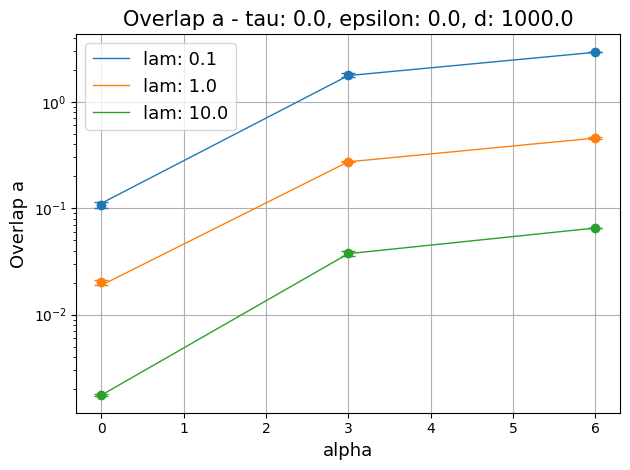

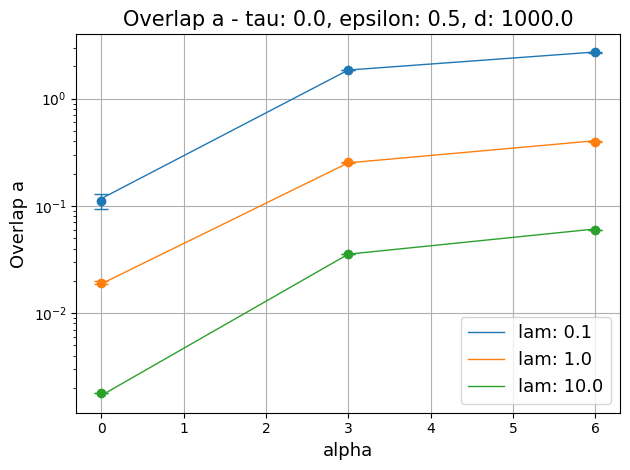

In [1864]:
# Plot the a overlap
create_plot(df, "Overlap a", "a_state_evolution","A_erm", log_y=True)

In [1865]:
# Plot the N_self overlap
# create_plot(df, "N_self", "N_self_state_evolution","N_erm", log_y=False)

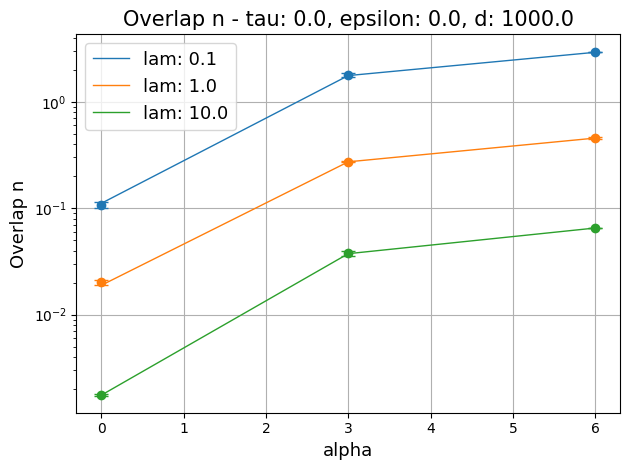

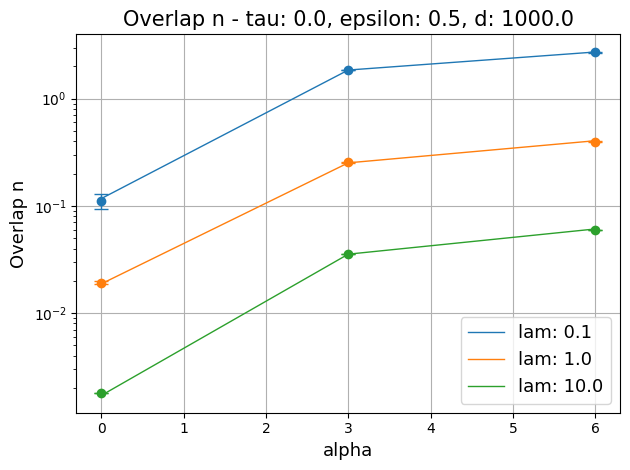

In [1866]:
# Plot the n overlap
create_plot(df, "Overlap n", "n_state_evolution","N_erm", log_y=True)

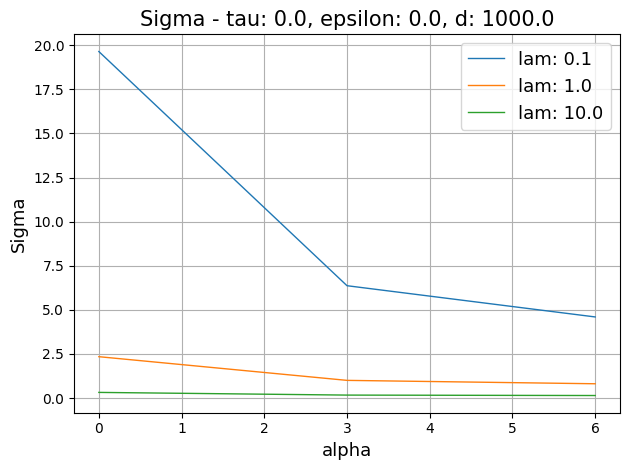

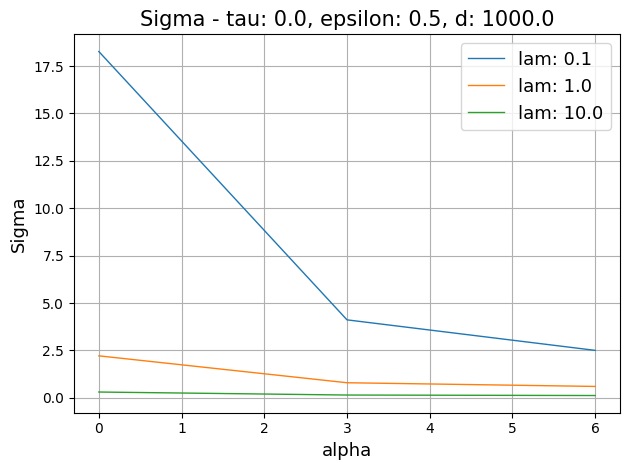

In [1867]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None, log_y=False)

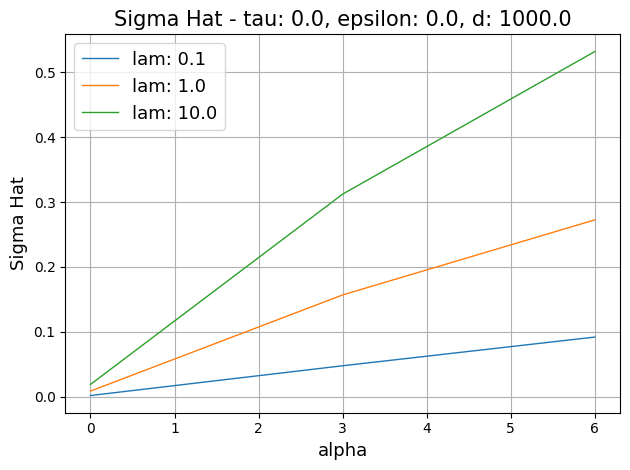

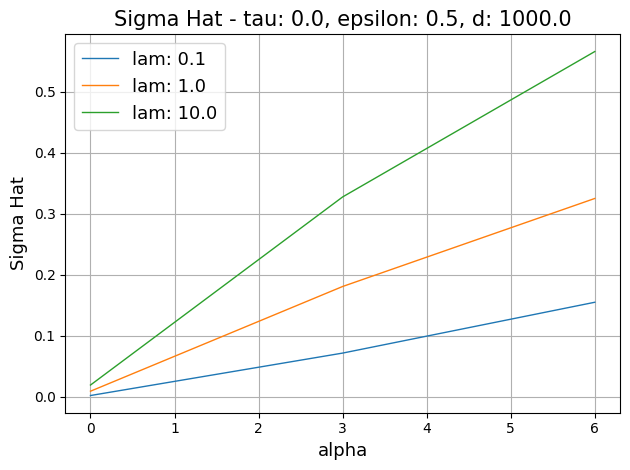

In [1868]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

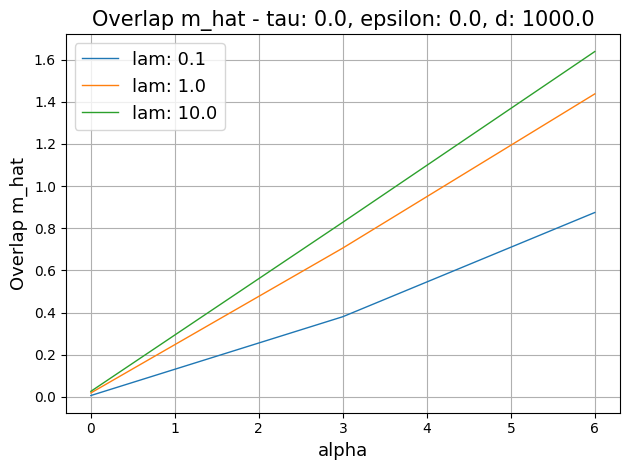

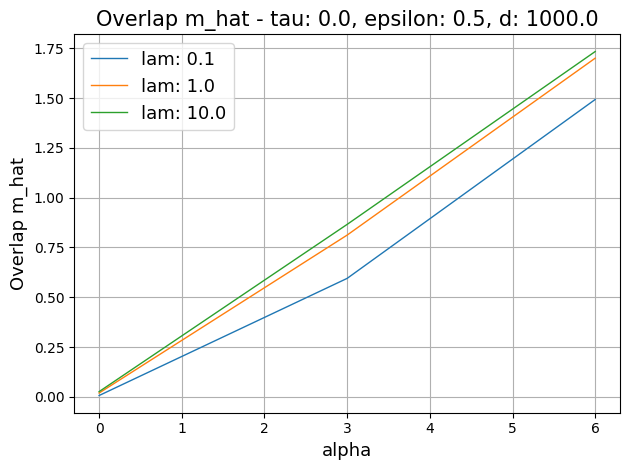

In [1869]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None, log_y=False)

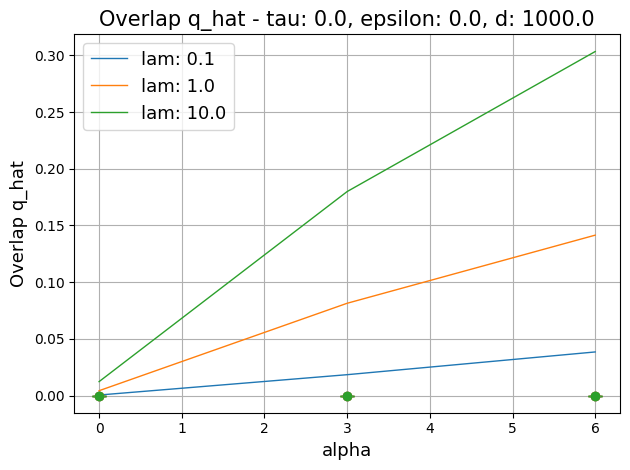

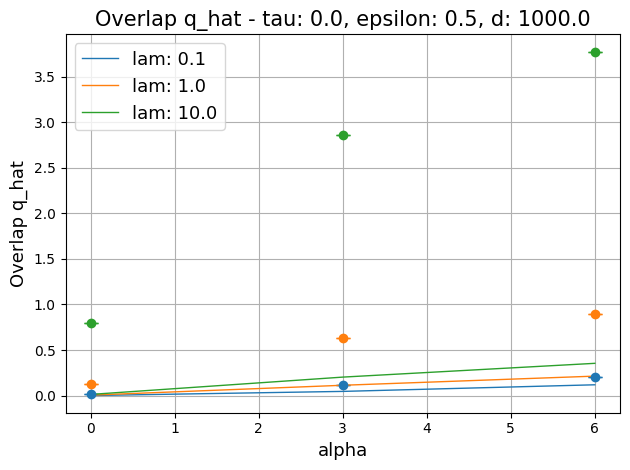

In [1870]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", "a_hat_state_evolution", log_y=False)

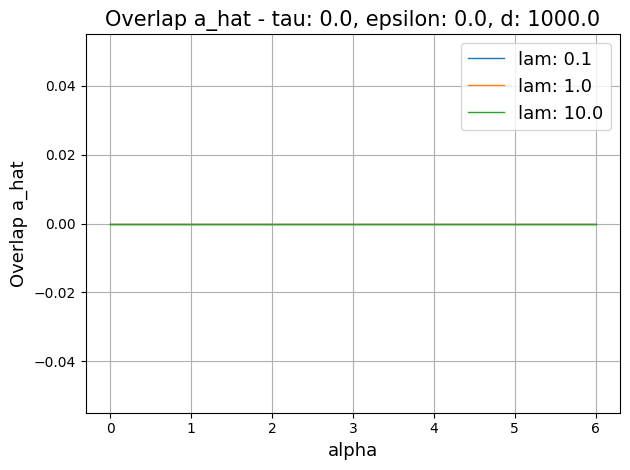

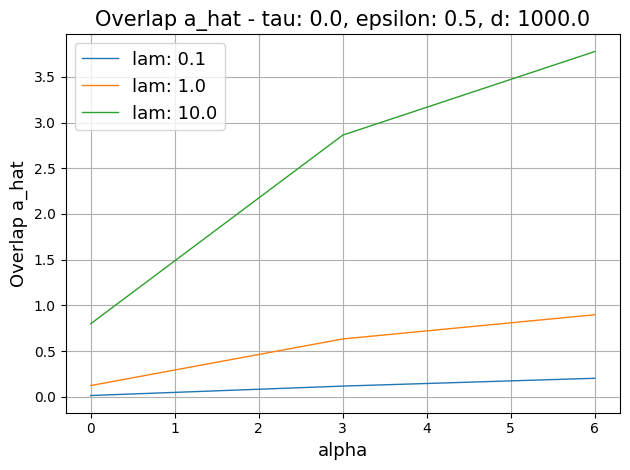

In [1871]:
# Plot the a_hat overlap for state_evolution
create_plot(df, "Overlap a_hat", "a_hat_state_evolution", None, log_y=False)

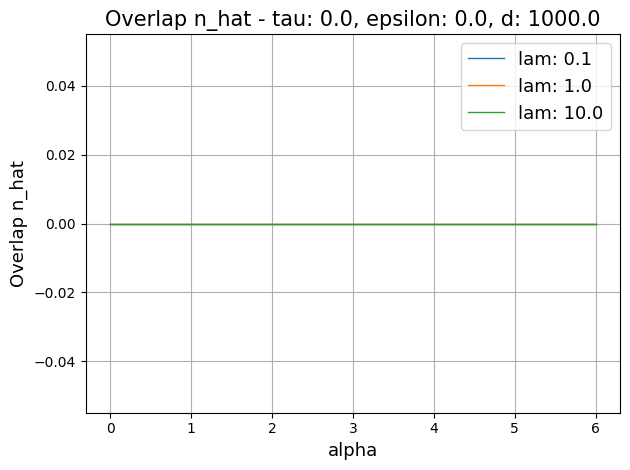

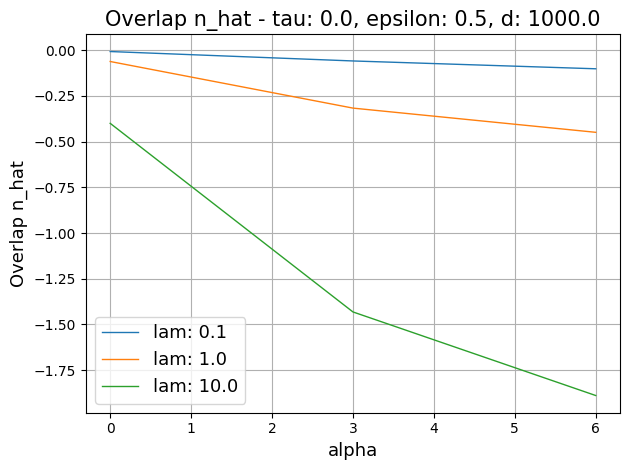

In [1872]:
# Plot the n_hat overlap for state_evolution   
create_plot(df, "Overlap n_hat", "n_hat_state_evolution", None, log_y=False)

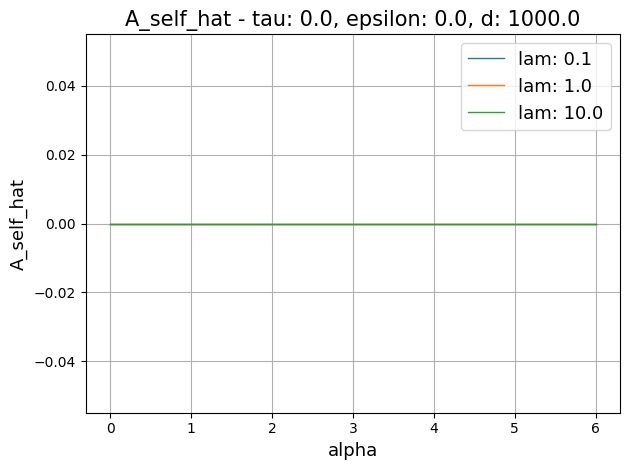

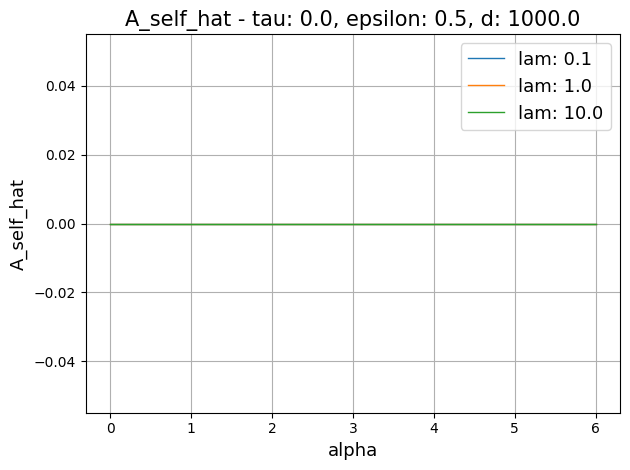

In [1873]:
# Plot the A_self_hat overlap for state_evolution
create_plot(df, "A_self_hat", "A_self_hat_state_evolution", None, log_y=False)

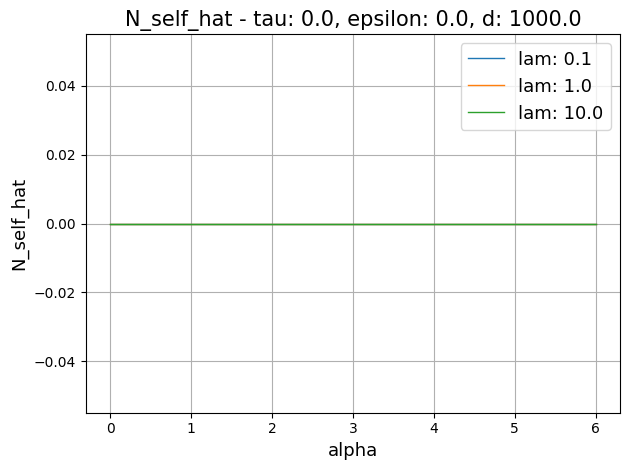

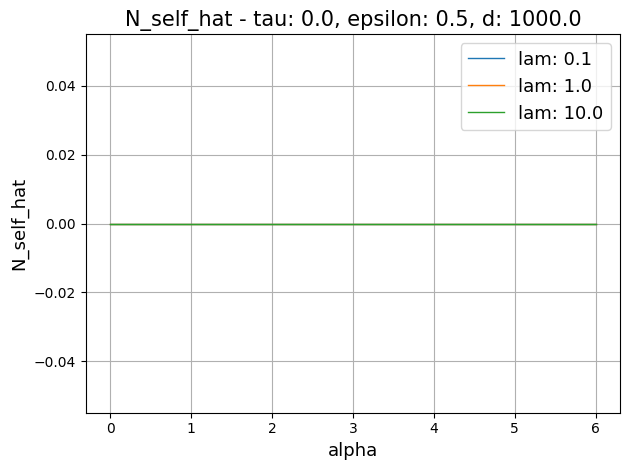

In [1874]:
# Plot the N_self_hat overlap for state_evolution
create_plot(df, "N_self_hat", "N_self_hat_state_evolution", None, log_y=False)

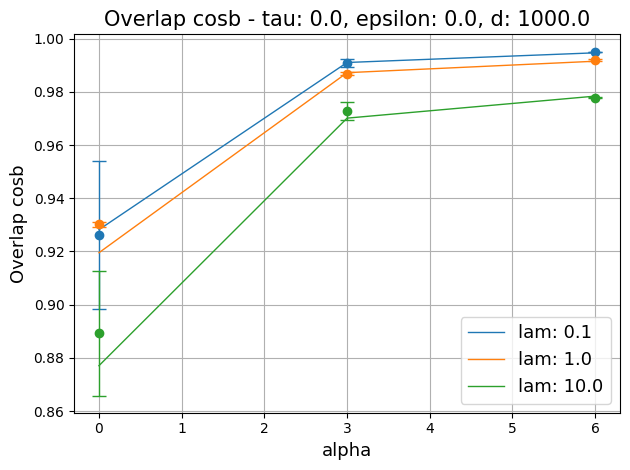

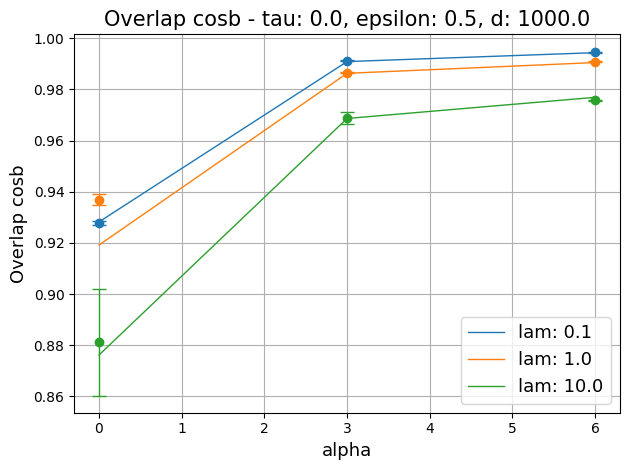

In [1875]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

In [1876]:
# subset df to keep only where p = 0.5
# p = 0.75
# dfp = df[df.index.get_level_values("p") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

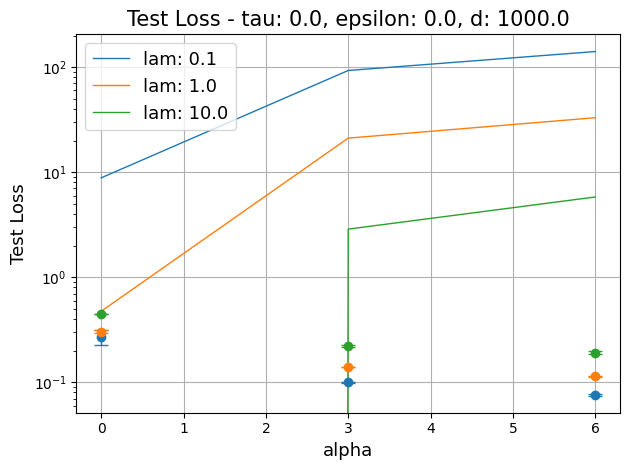

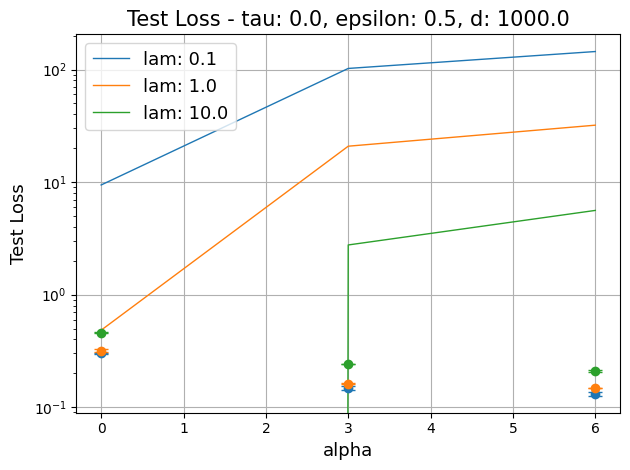

In [1877]:
# plot test loss erm
create_plot(df, "Test Loss", "estimation_error_state_evolution","test_loss_erm",log_y=True)

In [1878]:
# plot estimation_error_state_evolution
# create_plot(df, "Estimation Error", "estimation_error_state_evolution",None,log_y=True)

## Log-Log Plots of overlaps in State_evolution

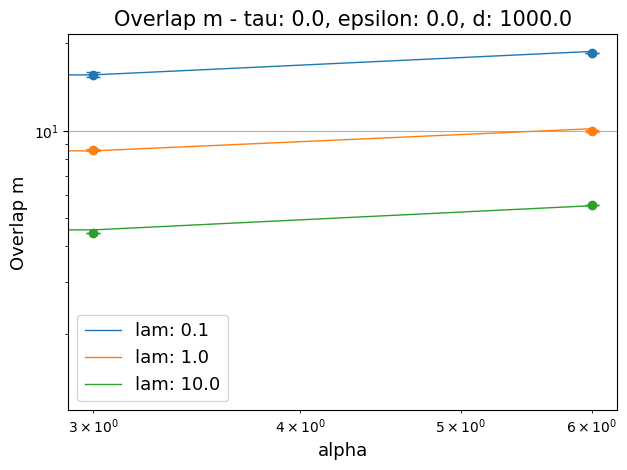

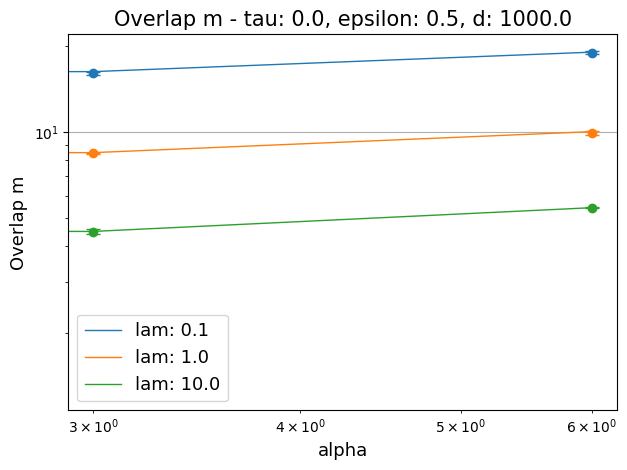

In [1879]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

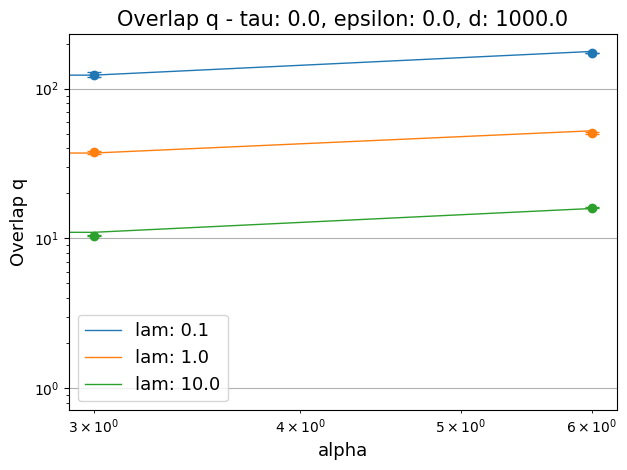

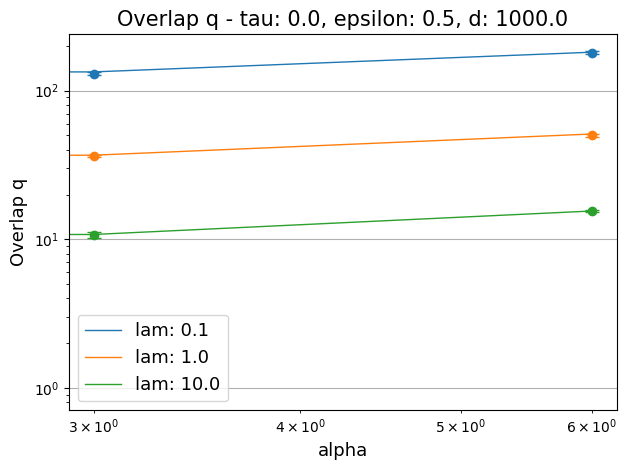

In [1880]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

In [1881]:
# create a log-log plot of the overlap sigma
# create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

In [1882]:
# create a log-log plot of the overlap sigma_hat
# create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

In [1883]:
# create a log-log plot of the overlap q_hat
# create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

In [1884]:
# create a log-log plot of the overlap m_hat
# create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)

In [1885]:
# p = d = 100
# Sigma_x = np.eye(p)

# Sigma_x[0,0] = 100

# Psi = Sigma_x
# Omega = Sigma_x
# Phi = np.eye(d)
# Phi = Sigma_x
# Sigma_w = np.eye(p)

# PhiPhiT = Phi @ Sigma_w @ Phi.T

# # Let's get the eigenvalues of Psi
# spec_Psi = np.linalg.eigvalsh(Psi)
# # Let's get the eigenvalues of Sigma_w
# spec_Sigma_w = np.linalg.eigvalsh(Sigma_w)
# rho = spec_Psi.dot(spec_Sigma_w) / p


# rhos = []
# phiphits = np.zeros((d,d))
# for _ in range(10000):


#     theta = np.random.multivariate_normal(np.zeros(p), Sigma_w)
#     A_PhiPhiT = (Phi @ theta.reshape(p,1) @ 
#                     theta.reshape(1,p) @ Phi.T)

#     phiphits += A_PhiPhiT

#     A_rho = theta.dot(Psi @ theta) / p
#     rhos.append(A_rho)

# exp_rho = np.mean(rhos)
# phiphits /= 10000

# print("exp_rho", exp_rho)
# print("rho", rho)
# print("std exp_rho", np.std(rhos))

# # print the mean difference between PhiPhiT and phiphits
# print("mean difference between PhiPhiT and phiphits", np.mean(np.abs(PhiPhiT - phiphits)))

In [1886]:
alph = 1.2
r = 0.3
p = 1000

spec_Omega0 = np.array([p/(k+1)**alph for k in range(p)])
Omega0=np.diag(spec_Omega0)
Phi = spec_Omega0
Psi = spec_Omega0

teacher = np.sqrt(np.array([1/(k+1)**((1+alph*(2*r-1))) for k in range(p)]))
rho = np.mean(Psi * teacher**2)
diagUtPhiPhitU0 = Phi**2 * teacher**2


In [1887]:
diagUtPhiPhitU0.shape

(1000,)

In [1888]:
np.linalg.norm(np.eye(1000))

31.622776601683793

In [1889]:
theta = np.sqrt(np.array([1/(k+1)**((1+alph*(2*r-1))) for k in range(1000)]))

In [1890]:
np.linalg.norm(np.diag(theta))

7.473378898608832

In [1891]:
np.linalg.norm(np.linalg.inv(np.diag(theta)))

154.611347639403

In [1892]:
spec_Omega0 = np.array([1000/(k+1)**alph for k in range(1000)])

In [1893]:
np.min(theta)

0.16595869074375605

In [1894]:
d = 10
n = 1000
alph = 1.2
r = 0.3


Sigma_x = np.diag(np.array([d/(k+1)**alph for k in range(d)]))
Sigma_x = np.eye(d)


avg = 0
for _ in range(n):    
    theta = np.random.normal(0,1,(d,))
    X = np.random.default_rng().multivariate_normal(np.zeros(d), Sigma_x, method="cholesky") 
    X = np.random.normal(0,1,(d,d))
    avg += np.linalg.norm(X @ theta)
avg /= n
avg

9.40115835781562

In [1895]:
avg_mu = 0
avg_no = 0
for _ in range(n):
    X = np.random.default_rng().multivariate_normal(np.zeros(d), np.eye(d), method="cholesky")
    avg_mu += np.linalg.norm(X)
    X = np.random.normal(0,1,(d,d))
    avg_no += np.linalg.norm(X)
avg_mu /= n
avg_no /= n
avg_mu, avg_no

(3.0876072792995775, 9.974560111402559)

In [1896]:
# d = 10
# n = 100000
# alpha = 1.0
# alph_w = 1.2
# r = 0.5
# r_w = 0.3


# Sigma_x = np.diag(np.array([d/(k+1)**alph for k in range(d)]))
# Sigma_w = np.diag(np.array([d/(k+1)**alph_w for k in range(d)]))
# # Sigma_x = np.eye(d)
# # Sigma_w = np.eye(d)
# Sigma_x = np.random.normal(0,1,(d,d))
# Sigma_x = Sigma_x.T @ Sigma_x + np.eye(d)
# Sigma_w = np.random.normal(0,1,(d,d))
# Sigma_w = Sigma_w.T @ Sigma_w + np.eye(d)
# combined = np.linalg.inv( np.linalg.inv(Sigma_w) + np.linalg.inv(Sigma_x) )

# mean_x = 0
# mean_w = 0
# mean_c = 0
# norm_x = 0
# norm_w = 0
# norm_c = 0
# ms = []


# for _ in range(n):
#     # sample from all the distributions
#     X = np.random.default_rng().multivariate_normal(np.zeros(d), Sigma_x, method="cholesky")
#     W = np.random.default_rng().multivariate_normal(np.zeros(d), Sigma_w, method="cholesky")
#     C = np.random.default_rng().multivariate_normal(np.zeros(d), combined, method="cholesky")
#     M = X.dot(W) / np.sqrt(np.trace(Sigma_x @ Sigma_w))
#     # compute the norms
#     norm_x += np.linalg.norm(X)
#     norm_w += np.linalg.norm(W)
#     norm_c += np.linalg.norm(C)
    
#     # compute the means
#     mean_x += np.mean(X)
#     mean_w += np.mean(W)
#     mean_c += np.mean(C)
#     ms.append(M)

# # compute the averages
# mean_x /= n
# mean_w /= n
# mean_c /= n
# norm_x /= n
# norm_w /= n
# norm_c /= n
# mean_m = np.mean(ms)
# std_m = np.std(ms)

# # print the results all means on one line and all norms on another line
# print(mean_x, mean_w, mean_c)
# print(norm_x, norm_w, norm_c)
# print(mean_m, std_m)

# # print the norms of the covariances Sigma_w and Sigma_x
# print(np.linalg.norm(Sigma_w), np.linalg.norm(Sigma_x), np.linalg.norm(combined))

In [1897]:
Sigma_x.shape

(10, 10)

In [1898]:
Sigma_w.shape

NameError: name 'Sigma_w' is not defined

In [ ]:
np.matmul(Sigma_x,Sigma_w)

NameError: name 'Sigma_w' is not defined

In [ ]:
Sigma_w * Sigma_x

NameError: name 'Sigma_w' is not defined

In [ ]:
Sigma_w @ Sigma_x

array([[ 6.59561628e+00,  4.19466086e+00,  1.10032685e-02,
        -1.82704074e-01, -1.46185108e+00,  5.93675472e-01,
         1.52091795e+00,  1.46573155e+00,  1.29985454e-01,
        -2.14996636e+00],
       [ 4.19466086e+00,  1.58910575e+01, -2.71151990e-01,
         5.76960376e+00,  4.14778907e+00,  1.39993391e+00,
         3.74353877e+00,  2.51144464e+00, -1.73457206e+00,
        -2.08759168e+00],
       [ 1.10032685e-02, -2.71151990e-01,  4.71370289e+00,
        -1.13301339e+00, -3.69933363e+00, -3.79721475e+00,
        -6.33098638e-03,  5.32377365e-02,  3.68700117e+00,
        -2.74034065e+00],
       [-1.82704074e-01,  5.76960376e+00, -1.13301339e+00,
         1.75524127e+01,  2.55307004e+00,  5.36553915e+00,
         3.74559717e+00,  6.19657863e+00,  4.00698233e-01,
         7.02037558e+00],
       [-1.46185108e+00,  4.14778907e+00, -3.69933363e+00,
         2.55307004e+00,  1.61984364e+01,  7.08333563e+00,
        -3.20139034e-01,  3.89397393e-01, -8.80225297e-01,
         3.